In [1]:
#Laod current hamiltonian file
using LinearAlgebra, Plots, Graphs, ProgressBars, Base.Threads, Statistics
include("../src/graphs.jl")
include("../src/observables.jl")

binned_average (generic function with 2 methods)

In [2]:
# parameters
SIZE_LIST = [20, 40, 80, 160] # number of sites
NUM_SAMPLES = 100
DISORDER_LIST = 10 .^ LinRange(-2, 3, 30) 


30-element Vector{Float64}:
    0.01
    0.01487352107293511
    0.022122162910704492
    0.03290344562312668
    0.04893900918477494
    0.07278953843983153
    0.10826367338740543
    0.16102620275609397
    0.23950266199874853
    0.3562247890262442
    ⋮
   41.75318936560402
   62.1016941891561
   92.36708571873865
  137.3823795883264
  204.33597178569417
  303.9195382313198
  452.03536563602404
  672.3357536499335
 1000.0

In [3]:
function compute_observables_per_size_and_disorder(sizes, disorders, num_samples)
    # get localization of the ground state as a function of disorder
    iprs = zeros(length(sizes), length(disorders))
    iprs_std = zeros(length(sizes), length(disorders))
    agrs = zeros(length(sizes), length(disorders))
    agrs_std = zeros(length(sizes), length(disorders))
    for (size_idx, L) in enumerate(sizes)
        graph = chain_graph(L, periodic=false)
        for (disorder_idx, disorder) in enumerate(disorders)
            ipr_sample_arr = zeros(num_samples)
            agr_sample_arr = zeros(num_samples)
            Threads.@threads for n in 1:num_samples
                chain_hamiltonian = hamiltonian_from_graph(graph, disorder * rand(nv(graph)), 1.0) 
                eigval_vec, eigvec_mat  = eigen(chain_hamiltonian)
                ipr_sample_arr[n] = inverse_participation_ratio(eigvec_mat[:, 1])
                agr_sample_arr[n] = adjacent_gap_ratio(eigval_vec)
            end
            iprs[size_idx, disorder_idx] = mean(ipr_sample_arr)
            iprs_std[size_idx, disorder_idx] = stdm(ipr_sample_arr, iprs[size_idx, disorder_idx])
            agrs[size_idx, disorder_idx] = mean(agr_sample_arr)
            agrs_std[size_idx, disorder_idx] = stdm(agr_sample_arr, agrs[size_idx, disorder_idx])
        end
    end
    return iprs, iprs_std, agrs, agrs_std
end

iprs_arr, iprs_std_arr, agrs_arr, agrs_std_arr = compute_observables_per_size_and_disorder(SIZE_LIST, DISORDER_LIST, NUM_SAMPLES)


([0.050018767666003223 0.05004309150768835 … 0.9977512232455221 0.9944426180876172; 0.0250645024906555 0.025195780110478353 … 0.9986268424185522 0.9972083008422759; 0.012781113970580977 0.013113927715236774 … 0.9932424595953102 0.993925517759669; 0.007312824649054479 0.00852817010319333 … 0.9937935768277714 0.9963500117938382], [1.833913393351732e-5 4.043848988193843e-5 … 0.01289122189151165 0.027709362596894386; 5.310952346292887e-5 0.0001667850956515299 … 0.005998090179614441 0.014582818468629485; 0.00027146746966523553 0.0004892821693755614 … 0.033441968033456546 0.04035221579352269; 0.000925687062887792 0.001562496519048845 … 0.03690338801808738 0.030649689087903345], [0.0034942442009657476 0.0053611667138837435 … 0.3990362481233685 0.3842086399093298; 0.006183679597865759 0.008890226266828257 … 0.390787177268397 0.38756961066812673; 0.010413208357803993 0.01591459015871988 … 0.38449602482332274 0.3829535606187985; 0.016978014865058618 0.02574351630616952 … 0.3856326252135498 0.387

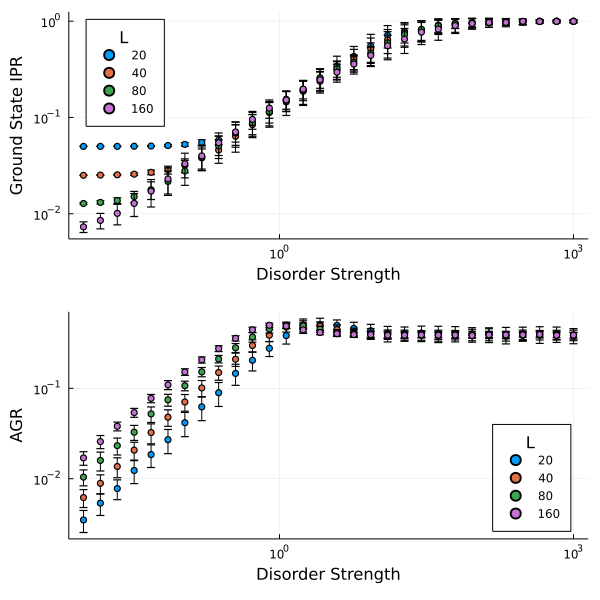

In [25]:
# Look at iprs as function of disorder
ipr_plot = scatter(
        # xaxis = :log,
        scale = :log,
        xlabel = "Disorder Strength",
        ylabel = "Ground State IPR",
        legend = :topleft,
        legendtitle = "L"
)

agr_plot = scatter(
    # xaxis = :log,
    scale = :log,
    xlabel = "Disorder Strength",
    ylabel = "AGR",
    legend = :bottomright,
    legendtitle = "L"
)

for (L, ipr, ipr_std) in zip(SIZE_LIST, eachrow(iprs_arr), eachrow(iprs_std_arr))
    scatter!(ipr_plot, DISORDER_LIST, ipr, yerror=ipr_std, label = L)
end

for (L, agr, agr_std) in zip(SIZE_LIST, eachrow(agrs_arr), eachrow(agrs_std_arr))
    scatter!(agr_plot, DISORDER_LIST, agr, yerror=agr_std, label = L)
end


plot(ipr_plot, agr_plot, layout=(2, 1), size=(600, 600))